In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
%cd ..

/cis/home/dpacker/my_documents/dark-matter-halos-2


In [2]:
from pathlib import Path
import pickle
import pandas as pd
import jax
from jax import numpy as jnp
import numpy as np
from src.subsampling.subsample import fix_torus
from matplotlib import patches, pyplot as plt
from sklearn.decomposition import PCA
from src.plotting.plotting import *
from tqdm.notebook import tqdm

root_path = Path(".")
data_path = root_path / "data"
generated_data_path = root_path / "generated_data_extended"
plot_path = root_path / "plots"

points_array, velocities_array, indices, halo_props = pickle.load(open(generated_data_path / "example_halos.pkl", 'rb'))
subsampled = jnp.load(generated_data_path / "kmeans_subsampled_n1_s75.npz")

In [36]:
scale = 10
t = 0
halos_to_plot : list[HaloInfo] = []
halo_props_to_plot = []
for scale in [9, 10, 11]:
    for ix in range(2):
        halos_to_plot.append(
            HaloInfo(
                all_points = fix_torus(points_array[scale][ix]),
                all_velocities = velocities_array[scale][ix],
                subsampled_points = subsampled["points"][indices[scale][ix], t],
                subsampled_velocities = subsampled["velocities"][indices[scale][ix], t],
                subsampled_weights = subsampled["weights"][indices[scale][ix], t],
            )
        )
        halo_props_to_plot.append(halo_props[scale][ix])


In [33]:
n_cols = 2
angle = 0
theta = 0.1

n_rows = len(halos_to_plot)


fig, axs = plt.subplots(n_rows, n_cols, figsize=(28, 16 * n_rows))

plotting_kwargs = {"scale_with_z_order": False, "rel_size" : 1, "tail_color": (0.9, 0.3, 0.2, 0.9)}
for i, halo_info in enumerate(halos_to_plot):
    plot_from_above_perturbed(
        angle,
        halo_info,
        axs[i, 0],
        **plotting_kwargs,
    )
    plot_from_above_perturbed(
        angle + theta,
        halo_info,
        axs[i, 1],
        **plotting_kwargs,
    )

plt.tight_layout()
fig.subplots_adjust(wspace=-0.3, hspace=0)
fig.savefig(plot_path / "example_of_subsampling.png")
plt.close()

In [81]:
t = 0
halos_to_plot : list[HaloInfo] = []
halo_props_to_plot = []
for scale in [9, 10, 11, 12, 13]:
    for ix in range(2):
        halos_to_plot.append(
            HaloInfo(
                all_points = fix_torus(points_array[scale][ix]),
                all_velocities = velocities_array[scale][ix],
                subsampled_points = subsampled["points"][indices[scale][ix], t],
                subsampled_velocities = subsampled["velocities"][indices[scale][ix], t],
                subsampled_weights = subsampled["weights"][indices[scale][ix], t],
            )
        )
        halo_props_to_plot.append(halo_props[scale][ix])


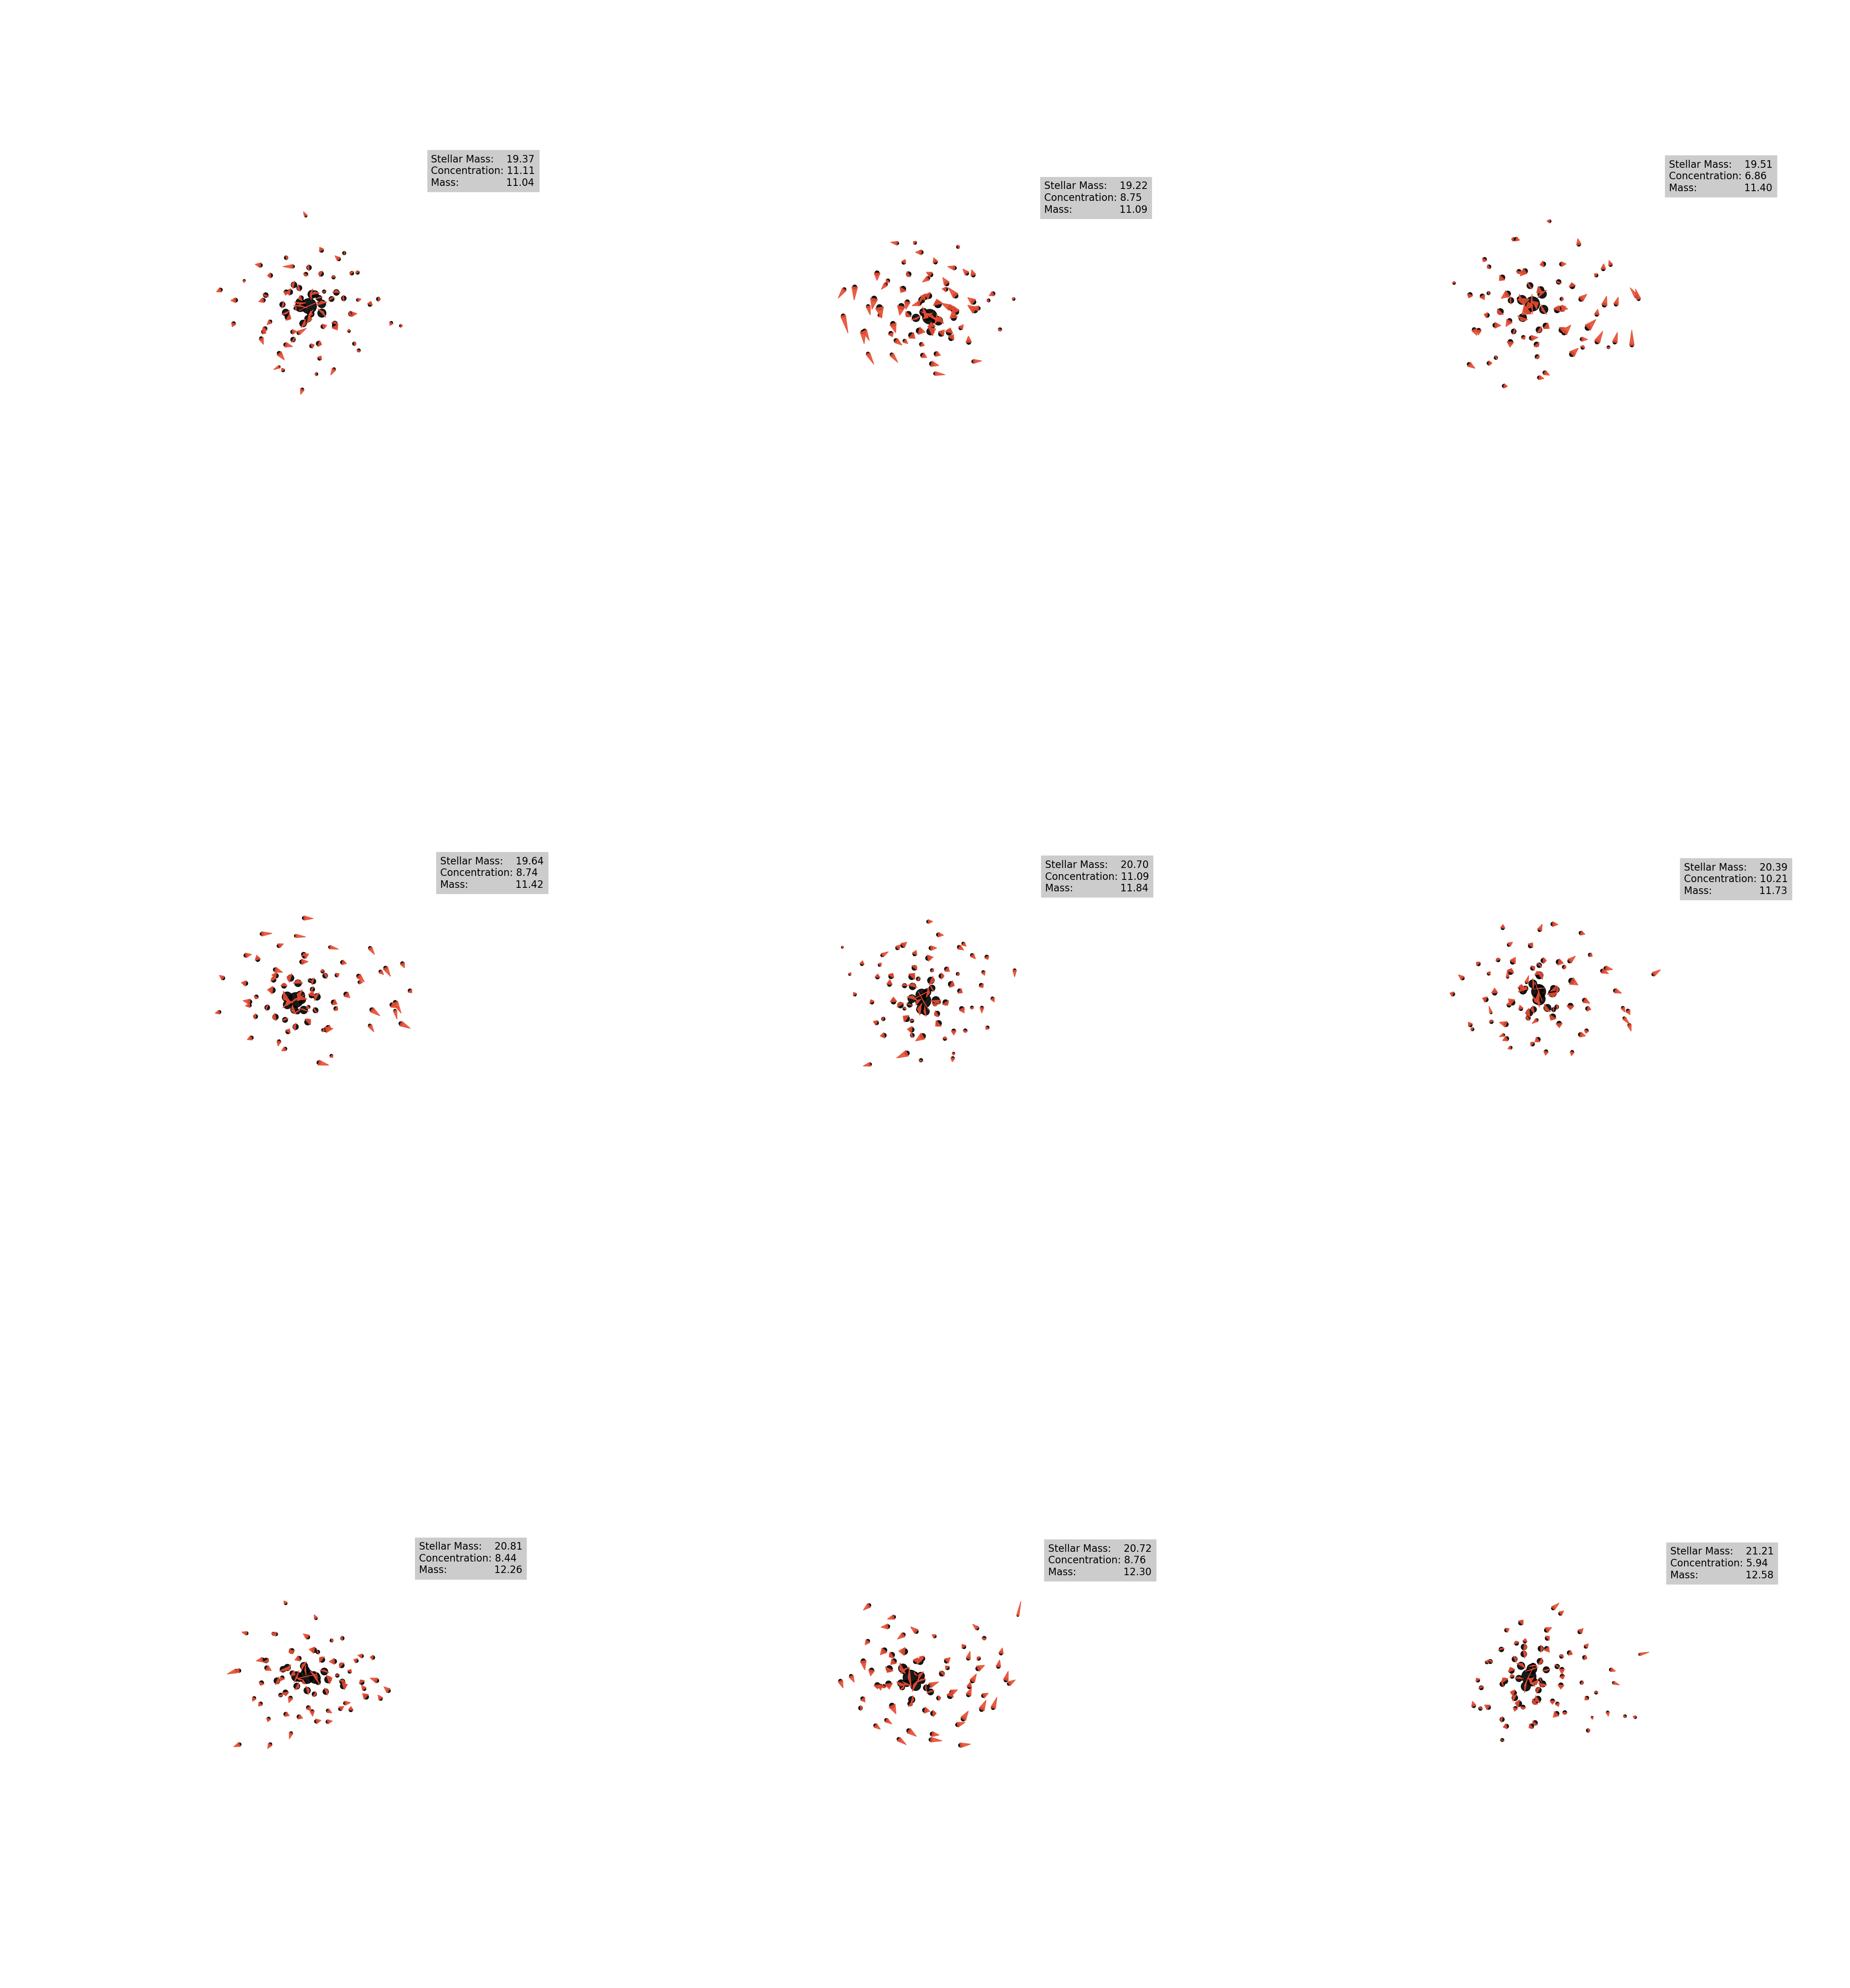

In [96]:
from typing import Dict


def plot_halo_info(
    ax: plt.Axes,
    halo_info: HaloInfo,
    halo_props_to_plot: Dict[str, float],
    tail_color: tuple[float] = (0.9, 0.3, 0.2, 0.9),
):
    center = np.mean(halo_info.subsampled_points, axis=0, keepdims=True)
    subsampled_points = halo_info.subsampled_points - center
    z = normalize(
        angular_momentum(
            subsampled_points,
            halo_info.subsampled_velocities,
            halo_info.subsampled_weights,
        )
    )
    points_in_plane = subsampled_points - (subsampled_points @ z)[:, None] * z[None, :]

    pca = PCA(n_components=3).fit(points_in_plane)
    x = pca.components_[0]
    y = pca.components_[1]

    max_radius = np.max(np.linalg.norm(points_in_plane, axis=0))
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    radii = 2 * np.power(halo_info.subsampled_weights * 1, 1 / power)
    sizes = (400 * np.square(radii) * np.pi,)

    points_subsampled_sliced = get_2d_slice(subsampled_points, x, y) / max_radius
    velocities_subsampled_sliced = (
        get_2d_slice(halo_info.subsampled_velocities, x, y) / max_radius
    )
    ax.scatter(
        points_subsampled_sliced[:, 0],
        points_subsampled_sliced[:, 1],
        s=sizes,
        color=np.array([0.0, 0.0, 0.0, 0.9]),
    )

    for ix in range(points_subsampled_sliced.shape[0]):
        tail = comet_tail(
            velocities_subsampled_sliced[ix] / 2,
            points_subsampled_sliced[ix],
            radii[ix] / 10,
            color=tail_color,
        )
        ax.add_patch(tail)

    stellar_mass = np.log10(halo_props_to_plot["StellarMass"] * 1e10 / 0.677)
    concentration = halo_props_to_plot["SubhaloC200"]
    mass = np.log10(halo_props_to_plot["Group_M_Crit200"])
    
    max_points = np.max(points_subsampled_sliced, axis=0)
    
    annotation = ax.annotate(
        f"""Stellar Mass:    {stellar_mass:.2f}\nConcentration: {concentration:.2f}\nMass:               {mass:.2f}""",
        (min(max_points[0] + 0.1, 0.65), min(max_points[1] + 0.1, 0.7)),
    )
    annotation.set(backgroundcolor=(0.8, 0.8, 0.8), fontsize=16)

    ax.axis("off")
    ax.set(aspect="equal")


n_rows, n_cols = 3, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 16 * n_rows))
axs = np.reshape(axs, (-1))

for i, ax in enumerate(axs):
    plot_halo_info(ax, halos_to_plot[i], halo_props_to_plot[i])
plt.tight_layout()